In [8]:
import re
import sys
import os
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy import cluster

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import PCprophet.io_ as io
import PCprophet.generate_features_allbyall as gf

In [35]:
infile = "..\\test\\test_frac.txt"
prot_dict = io.read_txt(path=infile)
clean_prot_dict = gf.clean_prot_dict(prot_dict)

Number of analyzed genes in ..\test\test_frac.txt: 47
Removed 0 empty or invalid keys from prot_dict.


In [43]:
first_protein = list(prot_dict.keys())[0]
fractions = np.arange(1, len(prot_dict[first_protein]) + 1)
intensities = np.array(prot_dict[first_protein])

In [44]:
def get_dynamic_initial_guesses(fractions, intensities, n_gaussians):
    # Smooth the intensities for peak detection (optional, reduces noise)
    smoothed_intensities = np.convolve(intensities, np.ones(3) / 3, mode='same')
    
    # Detect peaks
    peak_indices, properties = find_peaks(smoothed_intensities, height=np.mean(intensities))
    detected_peaks = len(peak_indices)
    print(f"Number of peaks detected: {detected_peaks}")
    
    # Sort peaks by intensity (most intense first)
    if detected_peaks > 0:
        sorted_indices = np.argsort(properties["peak_heights"])[::-1]
        peak_indices = peak_indices[sorted_indices]
        peak_heights = properties["peak_heights"][sorted_indices]
    else:
        peak_heights = []

    # Initialize guesses
    initial_guess = []
    for i in range(n_gaussians):
        if i < detected_peaks:
            # Use the most intense detected peaks for initial guesses
            fraction_guess = fractions[peak_indices[i]]
            amplitude_guess = peak_heights[i]
        else:
            # Fallback to random guesses if not enough peaks are detected
            fraction_guess = np.random.uniform(fractions.min(), fractions.max())
            amplitude_guess = np.random.uniform(0.5 * max(intensities), max(intensities))
        
        # Standard deviation guess
        std_guess = (fractions.max() - fractions.min()) / (2 * n_gaussians)  # Approximate width
        initial_guess.extend([amplitude_guess, fraction_guess, std_guess])
    
    return initial_guess

# Define a Gaussian function
def gaussian(x, amp, mean, std):
    return amp * np.exp(-0.5 * ((x - mean) / std) ** 2)

# Define a function that sums multiple Gaussians
def multi_gaussian(x, *params):
    n_gaussians = len(params) // 3
    result = np.zeros_like(x, dtype=np.float64)
    for i in range(n_gaussians):
        amp = params[i * 3]
        mean = params[i * 3 + 1]
        std = params[i * 3 + 2]
        result += gaussian(x, amp, mean, std)
    return result

# IC calculation function
def calculate_ic(y_true, y_pred, num_params, ic="BIC"):

    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    n = len(y_true)

    if ic == "AIC":
        ic = 2 * num_params + n * np.log(rss / n)

    elif ic == "BIC":
        ic = num_params * np.log(n) + n * np.log(rss / n)

    return ic

In [45]:
# Fit data with 1 to n_gaussians
n_gaussians_max = 5
best_fit = None
best_ic = np.inf
all_ics = []
all_fits = []

max_intensity = max(intensities)
initial_guess = []


for n_gaussians in range(1, n_gaussians_max + 1):
    # Generate dynamic initial guesses
    initial_guess = get_dynamic_initial_guesses(fractions, intensities, n_gaussians)
    
    try:
        # Fit the model
        params, _ = curve_fit(multi_gaussian, fractions, intensities, p0=initial_guess)
        
        # Calculate fitted curve and AIC
        fitted_curve = multi_gaussian(fractions, *params)
        ic = calculate_ic(intensities, fitted_curve, len(params), ic="BIC")
        all_ics.append(ic)
        all_fits.append(fitted_curve)
        print(f"n_components: {n_gaussians} - IC: {ic}")
        
        # Update best model if AIC improves
        if ic < best_ic:
            best_ic = ic
            best_fit = (n_gaussians, params, fitted_curve)
    except RuntimeError:
        # Skip cases where fitting fails
        print(f"Fitting failed for {n_gaussians} Gaussians.")
        all_ics.append(np.inf)
        all_fits.append(None)

# Extract best model
best_n_gaussians, best_params, best_fitted_curve = best_fit
gaussian_means = [best_params[i * 3 + 1] for i in range(best_n_gaussians)]

Number of peaks detected: 3
n_components: 1 - IC: 1457.2076912477448
Number of peaks detected: 3
n_components: 2 - IC: 1677.9516386819178
Number of peaks detected: 3
n_components: 3 - IC: 1690.4282879338166
Number of peaks detected: 3
Fitting failed for 4 Gaussians.
Number of peaks detected: 3
Fitting failed for 5 Gaussians.


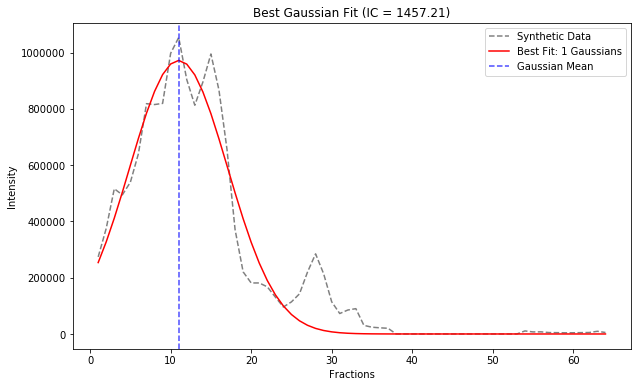

In [46]:
# Plot the data and the best fit
plt.figure(figsize=(10, 6))
plt.plot(fractions, intensities, label='Synthetic Data', color='gray', linestyle='dashed')
plt.plot(fractions, best_fitted_curve, label=f'Best Fit: {best_n_gaussians} Gaussians', color='red')
for mean in gaussian_means:
    plt.axvline(mean, color='blue', linestyle='--', alpha=0.7, label='Gaussian Mean' if mean == gaussian_means[0] else "")
plt.xlabel('Fractions')
plt.ylabel('Intensity')
plt.title(f'Best Gaussian Fit (IC = {best_ic:.2f})')
plt.legend()
plt.show()